In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from zeugma.embeddings import EmbeddingTransformer
from deslib.util.diversity import double_fault
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [0]:
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Extractors

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from preprocessing import *
from gensim.models.word2vec import Word2Vec
import matplotlib.lines as mlines
from matplotlib_venn import venn3_unweighted, venn3, venn3_circles, venn2, venn2_unweighted, venn2_circles


# Classifiers

In [0]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from deslib.util.aggregation import *

# Embedding

In [0]:
w2v = EmbeddingTransformer('word2vec')
glove = EmbeddingTransformer('glove')
fasttext = EmbeddingTransformer('fasttext')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
uri_train = 'https://raw.githubusercontent.com/wvs2/data-hate/master/wassen/train.csv'
uri_val   = 'https://raw.githubusercontent.com/wvs2/data-hate/master/wassen/val.csv'
uri_teste = 'https://raw.githubusercontent.com/wvs2/data-hate/master/wassen/test.csv'

df_train = pd.read_table(uri_train, sep=',')
df_val   = pd.read_table(uri_val, sep=',')
df_test = pd.read_table(uri_teste, sep=',')

In [0]:
train = df_train['text'].fillna(' ').apply(pre_processing)
val = df_val['text'].fillna(' ').apply(pre_processing)
test, class_test = df_test['text'].fillna(' ').apply(pre_processing), df_test['norm']

In [0]:
cv = CountVectorizer(analyzer='word', lowercase=True, stop_words='english')
cv.fit_transform(train.values.astype('U'))
     
tfidf =  TfidfVectorizer(analyzer='word', lowercase=True, use_idf=True, stop_words='english')
tfidf.fit_transform(train.values.astype('U'))

# Funções

In [0]:
def calc_delta(labels = {}, pred = {}, clfs=[]):
    size = len(clfs)
    delta = np.zeros(shape=(size, size))
    for i, clf1 in enumerate(clfs):
        for k, clf2 in enumerate(clfs):
            delta[i][k] = double_fault(labels, pred[clf1], pred[clf2])
    return delta, clfs

In [0]:
def gera_tsne(delta=[], title='', classifiers=[], size=5, escala=0, x_ini=0, y_ini=0,x_fim=0,y_fim=0, legend=False):
    simbolos = {}
    simbolos[0] = 'X'
    simbolos[1] = 'd'
    simbolos[2] = '*'
    simbolos[3] = "^"
    simbolos[4] = 'o'
    
    tsne_model = TSNE(perplexity=50, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(delta)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(size, size))
    plt.title(title)
    if escala > 0:
        plt.ylim(escala * -1, escala)
        plt.xlim(escala * -1, escala)
    else:
        plt.ylim(y_ini, y_fim)
        plt.xlim(x_ini, x_fim)
    
    dot = 0
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker=simbolos[dot], label=classifiers[i], s=100)        
        dot = dot+1
    if legend:
        plt.legend()
    plt.show()

In [0]:
def get_classifier(clf, statement, label, ext):
    pipe_clf = Pipeline([
        ('extractor', ext),
        ('clf', clf)
    ])
    pipe_clf.fit(statement, label)
    return pipe_clf

In [0]:
def get_CNN(ext, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=300, MAX_SEQUENCE_LENGTH=300, activation='sigmoid', word_embedding=False):
    if word_embedding==False:
        X_ext = ext.get_feature_names()
        model = Word2Vec([X_ext], min_count=1, workers=1, size=300)
    else:
        model = ext.model

    word_index = tokenizer.word_index
    
    nb_words = min(MAX_NB_WORDS, len(word_index))+1

    embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if word in model.wv.vocab:
            embedding_matrix[i] = model.wv.word_vec(word)

    embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False
    )
    cnn = Sequential()
    cnn.add(embedding_layer)
    cnn.add(Dropout(0.2))
    cnn.add(Conv1D(64, 3, padding='valid', activation='relu', strides=1))
    cnn.add(GlobalMaxPooling1D())
    cnn.add(Dense(256))
    cnn.add(Dropout(0.2))
    cnn.add(Activation('relu'))
    cnn.add(Dense(3))
    cnn.add(Activation(activation))
    cnn.summary()
    cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return cnn

In [0]:
def get_oracle(labels, pred={}, clfs=[]):
    cont = 0;
    list_yes = np.zeros((len(labels)))
    for i, k in enumerate(labels):
        acertou = False
        for clf in clfs:
            if pred[clf][i] == k:
                acertou = True
                break
        if acertou:
            cont += 1
            list_yes[i] = k
        else:
            if k == 0:
                list_yes[i] = 1
            else:
                list_yes[i] = 0
    return cont, list_yes


In [0]:
def tsne_full(labels,  delta , title='' , escala=0, size=5, x_ini=0, x_fim=0, y_ini=0, y_fim=0, espacamento=50, per=100 , lern=200.0, iterations=2500, ang=0.5, size_dot=10, cores={}, simbolos={}):
    tsne_model = TSNE(init='pca', early_exaggeration=espacamento, perplexity=per, learning_rate=lern, random_state=42, n_iter=iterations, angle=ang)
    new_values = tsne_model.fit_transform(delta)
    

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(size, size))
    plt.title(title)

    if escala > 0:
        plt.ylim(escala * -1, escala)
        plt.xlim(escala * -1, escala)
    else:
        plt.ylim(y_ini, y_fim)
        plt.xlim(x_ini, x_fim)
    
    dot = 0
    for i in range(len(x)):
        plt.scatter(x[i], y[i], s=size_dot,  marker=simbolos[dot], c=cores[dot])        
        
        if labels[i] == 'SVM-CV' and i==40:
            posicao=(5, -20)
        elif labels[i] == 'MNB-GL':
            posicao=(5, 25)
        elif i == 56:
            posicao=(5, 25)
        else:  
            posicao=(5, 8)


        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=posicao, textcoords='offset points', ha='center', va='bottom')  
        dot = dot+1
        if dot == 5:
            dot = 0

    m1 = mlines.Line2D([], [], color=cores[0], marker=simbolos[0], linestyle='None', markersize=10, label='CV')
    m2 = mlines.Line2D([], [], color=cores[1], marker=simbolos[1], linestyle='None', markersize=10, label='TFIDF')
    m3 = mlines.Line2D([], [], color=cores[2], marker=simbolos[2], linestyle='None', markersize=10, label='Word2Vec')
    m4 = mlines.Line2D([], [], color=cores[3], marker=simbolos[3], linestyle='None', markersize=10, label='Glove')
    m5 = mlines.Line2D([], [], color=cores[4], marker=simbolos[4], linestyle='None', markersize=10, label='FastText')
    

    plt.legend(handles=[m1, m2, m3, m4, m5])
    plt.show()

In [0]:
def diagrama_venn(p_a, p_b, p_c, label_a, label_b, label_c, txt):
  acertos_a = 0 
  acertos_a_b = 0
  acertos_a_c = 0
  acertos_b = 0
  acertos_b_c = 0
  acertos_c = 0
  acertos_juncao = 0
  

  for index, row in df_test.iterrows():
    #   print(p_a[index], row['norm'])
      pred_a = p_a[index]
      pred_b = p_b[index]
      pred_c = p_c[index]

      label = row['norm']
      if pred_a == label and pred_b == label and pred_c == label :
        acertos_juncao += 1
      if pred_a == label and pred_b != label and pred_c != label :
        acertos_a += 1 
      if pred_a != label and pred_b == label and pred_c != label :
        acertos_b += 1
      if pred_a != label and pred_b != label and pred_c == label :
        acertos_c += 1
      if pred_a == label and pred_b == label and pred_c != label :
        acertos_a_b += 1  
      if pred_a != label and pred_b == label and pred_c == label :
        acertos_b_c += 1   
      if pred_a == label and pred_b != label and pred_c == label :
        acertos_a_c += 1 


  plt.figure(figsize=(4,4))
  v = venn3_unweighted(subsets=(acertos_a, acertos_b, acertos_a_b ,acertos_c, acertos_a_c, acertos_b_c , acertos_juncao), set_labels = (label_a,  label_b,  label_c))
  v.get_patch_by_id('001').set_color('white')
  v.get_patch_by_id('100').set_color('white')
  v.get_patch_by_id('010').set_color('white')
  v.get_patch_by_id('111').set_color('white')
  v.get_patch_by_id('011').set_color('white')
  v.get_patch_by_id('110').set_color('white')
  v.get_patch_by_id('101').set_color('white')

  c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='solid')
  plt.title(txt)
  plt.show()

In [0]:
def diagrama_venn2(label, pred_a, pred_b, label_a, label_b, title):
    acertos_a = 0
    acertos_b = 0
    acertos_juncao = 0

    for i, l in enumerate(label):
        if pred_a[i] == l and pred_b[i] != l:
            acertos_a += 1
        if pred_a[i] != l and pred_b[i] == l:
            acertos_b += 1
        if pred_a[i] == l and pred_b[i] == l:
            acertos_juncao += 1

    plt.figure(figsize=(4,4))
    v = venn2_unweighted(subsets=(acertos_a, acertos_b, acertos_juncao), set_labels = (label_a,  label_b))
    v.get_patch_by_id('01').set_color('white')
    v.get_patch_by_id('10').set_color('white')
    v.get_patch_by_id('11').set_color('white')

    c = venn2_circles(subsets=(1, 1, 1), linestyle='solid')
    plt.title(title)
    plt.show()

In [0]:
def autolabel(rects, ax):
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
    xy=(
      rect.get_x() + rect.get_width() / 2, height),
      xytext=(0, 3),  # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom'
    )

def render_bar(list_certos, title='', size_x=0, size_y=0):    
    labels = [l for l in range(len(list_certos)-1, -1,-1)]
    
    # labels = [5, 4, 3, 2, 1, 0]
    x = np.arange(len(labels))
    width = 0.35 

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, list_certos.values(), width)

    ax.set_ylabel('Instâncias')
    ax.set_xlabel('Classificadores')
    ax.set_title('Classificadores x Instâncias: '+title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    autolabel(rects1, ax)
    fig.tight_layout()
    if size_x != 0:        
        plt.rcParams["figure.figsize"] = (size_y, size_x)
    plt.show()

In [0]:
def get_combine(data_test, clfs={}, cnn=False):
    list_proba = []

    for ext, clf in clfs.items():
        list_proba.append(clf.predict_proba(data_test))
    
    ensemble = np.array(list_proba).transpose((1, 0, 2))
    
    votes = np.zeros((test.shape[0], len(clfs)))
    k = 0
    for clf_index, clf in clfs.items():    
        if cnn == False:
            votes[:, k] = clf.predict(data_test).reshape(test.shape[0])
        else:
            votes[:, k] = np.argmax(clf.predict(data_test),axis=1).reshape(test.shape[0])
        k += 1
    
    return majority_voting_rule(votes), average_rule(ensemble), maximum_rule(ensemble), minimum_rule(ensemble), median_rule(ensemble), product_rule(ensemble)

In [0]:
def get_combine_all(d_test, d_test_cnn, clfs={}):
    list_proba = []

    for key, clf in clfs.items():
        if key[:3]=='CNN':
            list_proba.append(clf.predict_proba(d_test_cnn))
        else:
            list_proba.append(clf.predict_proba(d_test))
    
    ensemble = np.array(list_proba).transpose((1, 0, 2))
    
    votes = np.zeros((d_test.shape[0], len(clfs)))
    k = 0
    for key, clf in clfs.items():    
        if key[:3]=='CNN':
            votes[:, k] = np.argmax(clf.predict(d_test_cnn), axis=1).reshape(d_test.shape[0])            
        else:
            votes[:, k] = clf.predict(d_test).reshape(d_test.shape[0])            
        k += 1
    
    return majority_voting_rule(votes), average_rule(ensemble), maximum_rule(ensemble), minimum_rule(ensemble), median_rule(ensemble), product_rule(ensemble)

# SVM

In [0]:
svm = {
    'CV': {
        'CLF': SVC(random_state=42, verbose=100, kernel='rbf', gamma=0.1, probability=True),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': SVC(random_state=42, verbose=100, kernel='linear', gamma=0.1, probability=True),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': SVC(random_state=42, verbose=100, kernel='rbf', gamma=1, probability=True),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': SVC(random_state=42, verbose=100, kernel='linear', gamma=0.1, probability=True),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': SVC(random_state=42, verbose=100, kernel='linear', gamma=0.1, probability=True),
        'EXT': fasttext,
    }
}

In [0]:
svm_clfs = {

}
for ext, clf in svm.items():
    svm_clfs[ext] = get_classifier(clf['CLF'], train, df_train['norm'], clf['EXT'])


In [0]:
pre = {

}
for ext, clf in svm_clfs.items():
    pre['SVM-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['norm'], pre, pre.keys())

In [0]:
gera_tsne(delta, 'SVM', list(labels), escala=400)

# LogisticRegression

In [0]:
lr = {
    'CV': {
        'CLF': LogisticRegression(random_state=42, verbose=100, multi_class='auto', solver='liblinear', penalty='l1'),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': LogisticRegression(random_state=42, verbose=100, multi_class='auto', solver='liblinear', penalty='l1'),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': LogisticRegression(random_state=42, verbose=100, multi_class='auto', solver='liblinear', penalty='l1'),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': LogisticRegression(random_state=42, verbose=100, multi_class='auto', solver='liblinear', penalty='l1'),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': LogisticRegression(random_state=42, verbose=100, multi_class='auto', solver='liblinear', penalty='l1'),
        'EXT': fasttext,
    }
}

In [0]:
lr_clfs = {

}
for ext, clf in lr.items():
    lr_clfs[ext] = get_classifier(clf['CLF'], train, df_train['norm'], clf['EXT'])


In [0]:
pre_lr = {

}
for ext, clf in lr_clfs.items():
    pre_lr['LR-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['norm'], pre_lr, pre_lr.keys())

In [0]:
gera_tsne(delta, 'LogisticRegression', list(labels), escala=300)

In [0]:
pre.update(pre_lr)

# RandomForest

In [0]:
rf = {
    'CV': {
        'CLF': RandomForestClassifier(random_state=42, verbose=100, n_estimators=20),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': RandomForestClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': RandomForestClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': RandomForestClassifier(random_state=42, verbose=100, n_estimators=20),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': RandomForestClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': fasttext,
    }
}

In [0]:
rf_clfs = {

}
for ext, clf in rf.items():
    rf_clfs[ext] = get_classifier(clf['CLF'], train, df_train['norm'], clf['EXT'])


In [0]:
pre_rf = {

}
for ext, clf in rf_clfs.items():
    pre_rf['RF-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['norm'], pre_rf, pre_rf.keys())

In [0]:
gera_tsne(delta, 'RandomForest', list(labels), escala=300)

In [0]:
pre.update(pre_rf)

# NaiveBayes

In [0]:
nb = {
    'CV': {
        'CLF': MultinomialNB(alpha=1, fit_prior=True),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': MultinomialNB(alpha=0.1, fit_prior=True),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': BernoulliNB(alpha=0.1, fit_prior=True),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': BernoulliNB(alpha=0.1, fit_prior=True),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': BernoulliNB(alpha=1, fit_prior=True),
        'EXT': fasttext,
    }
}

In [0]:
nb_clfs = {

}
for ext, clf in nb.items():
    nb_clfs[ext] = get_classifier(clf['CLF'], train, df_train['norm'], clf['EXT'])


In [0]:
pre_nb = {

}
for ext, clf in nb_clfs.items():
    pre_nb['NB-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['norm'], pre_nb, pre_nb.keys())

In [0]:
gera_tsne(delta, 'NaiveBayes', list(labels), escala=350)

In [0]:
pre.update(pre_nb)

# MLP

In [0]:
mlp = {
    'CV': {
        'CLF': MLPClassifier(random_state=42, batch_size=20, max_iter=20, verbose=100, activation='relu', solver='lbfgs'),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': MLPClassifier(random_state=42, batch_size=20, max_iter=20, verbose=100, activation='relu', solver='lbfgs'),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': MLPClassifier(random_state=42, batch_size=20, max_iter=20, verbose=100, activation='relu', solver='adam'),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': MLPClassifier(random_state=42, batch_size=20, max_iter=20, verbose=100, activation='relu', solver='adam'),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': MLPClassifier(random_state=42, batch_size=20, max_iter=20, verbose=100, activation='relu', solver='adam'),
        'EXT': fasttext,
    }
}

In [0]:
mlp_clfs = {

}
for ext, clf in mlp.items():
    mlp_clfs[ext] = get_classifier(clf['CLF'], train, df_train['norm'], clf['EXT'])


In [0]:
pre_mlp = {

}
for ext, clf in mlp_clfs.items():
    pre_mlp['MLP-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['norm'], pre_mlp, pre_mlp.keys())

In [0]:
gera_tsne(delta, 'MLP', list(labels), escala=400)

In [0]:
pre.update(pre_mlp)

# ExtraTrees

In [0]:
extra = {
    'CV': {
        'CLF': ExtraTreesClassifier(random_state=42, verbose=100, n_estimators=20),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': ExtraTreesClassifier(random_state=42, verbose=100, n_estimators=20),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': ExtraTreesClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': ExtraTreesClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': ExtraTreesClassifier(random_state=42, verbose=100, n_estimators=50),
        'EXT': fasttext,
    }
}

In [0]:
extra_clfs = {

}
for ext, clf in extra.items():
    extra_clfs[ext] = get_classifier(clf['CLF'], train, df_train['norm'], clf['EXT'])


In [0]:
pre_extra = {

}
for ext, clf in extra_clfs.items():
    pre_extra['EXTRA-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['norm'], pre_extra, pre_extra.keys())

In [0]:
gera_tsne(delta, 'EXTRATREES', list(labels), escala=400)

In [0]:
pre.update(pre_extra)

# KNN

In [0]:
knn = {
    'CV': {
        'CLF': KNeighborsClassifier(n_neighbors=5, algorithm='auto'),
        'EXT': cv,
    },
    'TFIDF': {
        'CLF': KNeighborsClassifier(n_neighbors=3, algorithm='auto'),
        'EXT': tfidf,
    },
    'W2V': {
        'CLF': KNeighborsClassifier(n_neighbors=5, algorithm='auto'),
        'EXT': w2v,
    },
    'GLOVE': {
        'CLF': KNeighborsClassifier(n_neighbors=5, algorithm='auto'),
        'EXT':  glove,
    },
    'FAST': {
        'CLF': KNeighborsClassifier(n_neighbors=5, algorithm='auto'),
        'EXT': fasttext,
    }
}

In [0]:
knn_clfs = { }
for ext, clf in knn.items():
    knn_clfs[ext] = get_classifier(clf['CLF'], train, df_train['norm'], clf['EXT'])

In [0]:
pre_knn = { }
for ext, clf in knn_clfs.items():
    pre_knn['KNN-'+ext] = clf.predict(val)

In [0]:
delta, labels = calc_delta(df_val['norm'], pre_knn, pre_knn.keys())

In [0]:
gera_tsne(delta, 'KNN', list(labels), escala=600)

In [0]:
pre.update(pre_knn)

# CNN

In [0]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH=300

y_train = to_categorical(df_train['norm'])
y_val = to_categorical(df_val['norm'])

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train)

In [0]:
seq_train = tokenizer.texts_to_sequences(train)
seq_val = tokenizer.texts_to_sequences(val)
seq_test = tokenizer.texts_to_sequences(test)

In [0]:
data_train = pad_sequences(seq_train, maxlen=MAX_SEQUENCE_LENGTH)
data_val = pad_sequences(seq_val, maxlen=MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(seq_test, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
cnn_cv = get_CNN(cv, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=300, activation='sigmoid')

In [0]:
cnn_cv.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=20)

In [0]:
cnn_tfidf = get_CNN(tfidf, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=300, activation='softmax')

In [0]:
cnn_tfidf.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=200)

In [0]:
cnn_w2v = get_CNN(w2v, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=300, activation='sigmoid', word_embedding=True)

In [0]:
cnn_w2v.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=200)

In [0]:
cnn_glove = get_CNN(glove, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=25, activation='sigmoid', word_embedding=True)

In [0]:
cnn_glove.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=200)

In [0]:
cnn_fast = get_CNN(fasttext, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM=300, activation='sigmoid', word_embedding=True)

In [0]:
cnn_fast.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=200)

In [0]:
pre_cnn = {
    'CNN-CV': np.argmax(cnn_cv.predict(data_val), axis=1),
    'CNN-TFIDF': np.argmax(cnn_tfidf.predict(data_val), axis=1),
    'CNN-W2V': np.argmax(cnn_w2v.predict(data_val), axis=1),
    'CNN-GLOVE': np.argmax(cnn_glove.predict(data_val), axis=1),
    'CNN-FAST': np.argmax(cnn_fast.predict(data_val), axis=1),
}

In [0]:
delta, labels = calc_delta(df_val['norm'], pre_cnn, pre_cnn.keys())

In [0]:
gera_tsne(delta, 'CNN', list(labels), escala=300)

In [0]:
pre.update(pre_cnn)

# PREDICT TEST

In [0]:
pre_test = {}

for ext, clf in svm_clfs.items():
    pre_test['SVM-'+ext] = clf.predict(test)

In [0]:
for ext, clf in lr_clfs.items():
    pre_test['LR-'+ext] = clf.predict(test)

In [0]:
for ext, clf in rf_clfs.items():
    pre_test['RF-'+ext] = clf.predict(test)

In [0]:
for ext, clf in nb_clfs.items():
    pre_test['NB-'+ext] = clf.predict(test)

In [0]:
for ext, clf in mlp_clfs.items():
    pre_test['MLP-'+ext] = clf.predict(test)

In [0]:
for ext, clf in extra_clfs.items():
    pre_test['EXTRA-'+ext] = clf.predict(test)

In [0]:
for ext, clf in knn_clfs.items():
    pre_test['KNN-'+ext] = clf.predict(test)

In [0]:
pre_test['CNN-CV'] = np.argmax(cnn_cv.predict(data_test), axis=1)
pre_test['CNN-TFIDF'] = np.argmax(cnn_tfidf.predict(data_test), axis=1)
pre_test['CNN-W2V'] = np.argmax(cnn_w2v.predict(data_test), axis=1)
pre_test['CNN-GLOVE'] = np.argmax(cnn_glove.predict(data_test), axis=1)
pre_test['CNN-FAST'] = np.argmax(cnn_fast.predict(data_test), axis=1)

In [0]:
k = 0
for clf, pre_clf in pre_test.items():
    print(clf)
    print(f1_score(class_test, pre_clf, average='macro'))
    print(accuracy_score(class_test, pre_clf))
    k += 1
    if k % 5 == 0:
        print("")
    

# ORACLE

In [0]:
clfs = ['SVM-CV', 'SVM-TFIDF', 'SVM-W2V', 'SVM-GLOVE', 'SVM-FAST']

oracle, df_yes = get_oracle(df_test['norm'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['norm'], df_yes))
print('F1: ', f1_score(df_test['norm'], df_yes, average='macro'))

In [0]:
clfs = ['LR-CV', 'LR-TFIDF', 'LR-W2V', 'LR-GLOVE', 'LR-FAST']

oracle, df_yes = get_oracle(df_test['norm'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['norm'], df_yes))
print('F1: ', f1_score(df_test['norm'], df_yes, average='macro'))

In [0]:
clfs = ['RF-CV', 'RF-TFIDF', 'RF-W2V', 'RF-GLOVE', 'RF-FAST']

oracle, df_yes = get_oracle(df_test['norm'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['norm'], df_yes))
print('F1: ', f1_score(df_test['norm'], df_yes, average='macro'))

In [0]:
clfs = ['NB-CV', 'NB-TFIDF', 'NB-W2V', 'NB-GLOVE', 'NB-FAST']

oracle, df_yes = get_oracle(df_test['norm'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['norm'], df_yes))
print('F1: ', f1_score(df_test['norm'], df_yes, average='macro'))

In [0]:
clfs = ['MLP-CV', 'MLP-TFIDF', 'MLP-W2V', 'MLP-GLOVE', 'MLP-FAST']

oracle, df_yes = get_oracle(df_test['norm'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['norm'], df_yes))
print('F1: ', f1_score(df_test['norm'], df_yes, average='macro'))

In [0]:
clfs = ['EXTRA-CV', 'EXTRA-TFIDF', 'EXTRA-W2V', 'EXTRA-GLOVE', 'EXTRA-FAST']

oracle, df_yes = get_oracle(df_test['norm'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['norm'], df_yes))
print('F1: ', f1_score(df_test['norm'], df_yes, average='macro'))

In [0]:
clfs = ['KNN-CV', 'KNN-TFIDF', 'KNN-W2V', 'KNN-GLOVE', 'KNN-FAST']

oracle, df_yes = get_oracle(df_test['norm'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['norm'], df_yes))
print('F1: ', f1_score(df_test['norm'], df_yes, average='macro'))

In [0]:
clfs = ['CNN-CV', 'CNN-TFIDF', 'CNN-W2V', 'CNN-GLOVE', 'CNN-FAST']

oracle, df_yes = get_oracle(df_test['norm'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['norm'], df_yes))
print('F1: ', f1_score(df_test['norm'], df_yes, average='macro'))

# TSNE-FULL

In [0]:
delta, cols = calc_delta(df_val['norm'], pre, pre.keys())

In [0]:
cores = {}
cores[0] = '#DAA520'
cores[1] = '#FF0000'
cores[2] = '#0000FF'
cores[3] = '#228B22'
cores[4] = '#000000'

simbolos = {}
simbolos[0] = 'X'
simbolos[1] = 'd'
simbolos[2] = '*'
simbolos[3] = "^"
simbolos[4] = 'o'

tsne_full(list(cols), delta, 'Todos', cores=cores, simbolos=simbolos, x_ini=-70, x_fim=80, y_ini=-70, y_fim=120, size=10, size_dot=70, per=25)

# Oracle Combinados

In [0]:
# TODOS
clfs = list(pre.keys())

oracle, df_yes = get_oracle(df_test['norm'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['norm'], df_yes))
print('F1: ', f1_score(df_test['norm'], df_yes, average='macro'))

In [0]:
# EXTERNOS
clfs = ['NB-GLOVE', 'SVM-FAST', 'CNN-GLOVE', 'NB-FAST', 'EXTRA-TFIDF']

oracle, df_yes = get_oracle(df_test['norm'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['norm'], df_yes))
print('F1: ', f1_score(df_test['norm'], df_yes, average='macro'))

In [0]:
clfs = ['LR-W2V','SVM-W2V', 'KNN-FAST', 'LR-FAST', 'CNN-TFIDF']

oracle, df_yes = get_oracle(df_test['norm'], pre_test, clfs)

print("{} de {}".format(oracle, df_test.shape[0]))
print('Acc: ', accuracy_score(df_test['norm'], df_yes))
print('F1: ', f1_score(df_test['norm'], df_yes, average='macro'))

# VENN

In [0]:
diagrama_venn(pre_test['SVM-CV'], pre_test['EXTRA-GLOVE'], pre_test['MLP-W2V'], 'LR-CV', 'NB-W2V', 'RF-GLOVE', 'Conjunto 1')

In [0]:
diagrama_venn(pre_test['EXTRA-CV'], pre_test['CNN-W2V'], pre_test['EXTRA-FAST'], 'EXTRA-TFIDF', 'RF-W2V', 'LR-CV', 'Conjunto 2')

In [0]:
diagrama_venn2(df_test['norm'], pre_test['KNN-TFIDF'], pre_test['SVM-GLOVE'], 'KNN-TFIDF', 'SVM-GLOVE', 'Conjunto 3')

In [0]:
diagrama_venn2(df_test['norm'], pre_test['KNN-TFIDF'], pre_test['MLP-CV'], 'KNN-TFIDF', 'MLP-CV', 'Conjunto 4')

# BAR



In [0]:
list_certos = {
    5: 0, 4: 0, 3: 0, 2:0, 1:0, 0:0
}
EXTS = ['CV','TFIDF', 'W2V','GLOVE', 'FAST']

In [0]:
svm_certos = list_certos.copy()
for i, l in enumerate(df_test['norm']):
    k = 0
    for ext in EXTS:
        if pre_test['SVM-'+ext][i]==l:
            k += 1
    svm_certos[k] = svm_certos[k]+1

render_bar(svm_certos, title='SVM')

In [0]:
lr_certos = list_certos.copy()
for i, l in enumerate(df_test['norm']):
    k = 0
    for ext in EXTS:
        if pre_test['LR-'+ext][i]==l:
            k += 1
    lr_certos[k] = lr_certos[k]+1

render_bar(lr_certos, title='LogisticRegression')

In [0]:
rf_certos = list_certos.copy()
for i, l in enumerate(df_test['norm']):
    k = 0
    for ext in EXTS:
        if pre_test['RF-'+ext][i]==l:
            k += 1
    rf_certos[k] = rf_certos[k]+1

render_bar(rf_certos, title='RandomForest')

In [0]:
nb_certos = list_certos.copy()
for i, l in enumerate(df_test['norm']):
    k = 0
    for ext in EXTS:
        if pre_test['NB-'+ext][i]==l:
            k += 1
    nb_certos[k] = nb_certos[k]+1

render_bar(nb_certos, title='NaiveBayes')

In [0]:
mlp_certos = list_certos.copy()
for i, l in enumerate(df_test['norm']):
    k = 0
    for ext in EXTS:
        if pre_test['MLP-'+ext][i]==l:
            k += 1
    mlp_certos[k] = mlp_certos[k]+1

render_bar(mlp_certos, title='MLP')

In [0]:
extra_certos = list_certos.copy()
for i, l in enumerate(df_test['norm']):
    k = 0
    for ext in EXTS:
        if pre_test['EXTRA-'+ext][i]==l:
            k += 1
    extra_certos[k] = extra_certos[k]+1

render_bar(extra_certos, title='ExtraTrees')

In [0]:
knn_certos = list_certos.copy()
for i, l in enumerate(df_test['norm']):
    k = 0
    for ext in EXTS:
        if pre_test['KNN-'+ext][i]==l:
            k += 1
    knn_certos[k] = knn_certos[k]+1

render_bar(knn_certos, title='KNN')

In [0]:
cnn_certos = list_certos.copy()
for i, l in enumerate(df_test['norm']):
    k = 0
    for ext in EXTS:
        if pre_test['CNN-'+ext][i]==l:
            k += 1
    cnn_certos[k] = cnn_certos[k]+1

render_bar(cnn_certos, title='CNN')

In [0]:
clfs_combinados = ['NB-GLOVE', 'SVM-FAST', 'CNN-GLOVE', 'NB-FAST', 'EXTRA-TFIDF']
clfs_combinados_certos = list_certos.copy()
for i, l in enumerate(df_test['norm']):
    k = 0
    for clf in clfs_combinados:
        if pre_test[clf][i]==l:
            k += 1
    clfs_combinados_certos[k] = clfs_combinados_certos[k]+1

render_bar(clfs_combinados_certos, title='Combinados (B)')

In [0]:
clfs_combinados = ['LR-W2V','SVM-W2V', 'KNN-FAST', 'LR-FAST', 'CNN-TFIDF']
clfs_combinados_certos = list_certos.copy()
for i, l in enumerate(df_test['norm']):
    k = 0
    for clf in clfs_combinados:
        if pre_test[clf][i]==l:
            k += 1
    clfs_combinados_certos[k] = clfs_combinados_certos[k]+1

render_bar(clfs_combinados_certos, title='Combinados (C)')

No handles with labels found to put in legend.


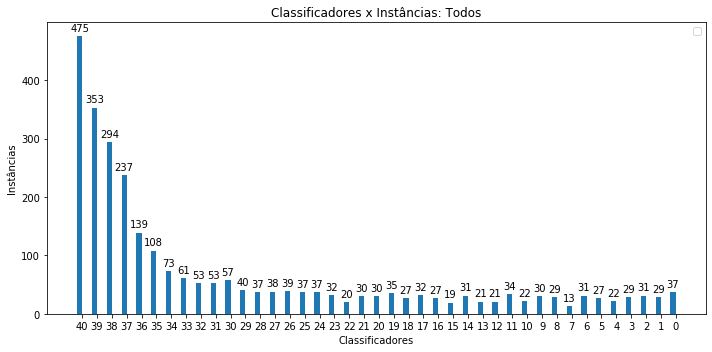

In [0]:
clfs_todos = list(pre.keys())
clfs_todos_certos = {k:0 for k in range(len(clfs_todos), -1, -1)}
for i, l in enumerate(df_test['norm']):
    k = 0
    for clf in clfs_todos:
        if pre_test[clf][i]==l:
            k += 1
    clfs_todos_certos[k] = clfs_todos_certos[k]+1
render_bar(clfs_todos_certos, title='Todos', size_x=5, size_y=10)

# COMBINE

In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, svm_clfs)

In [0]:
print("SVM")
print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

SVM
Voting
0.6844190173954742
0.7960573476702509
Average
0.7157183506823902
0.8093189964157707
Maximun
0.7246264897256722
0.8100358422939068
Minimun
0.6913066132481633
0.7992831541218638
Median
0.7041830560278793
0.8043010752688172
Product
0.7099291334989276
0.8064516129032258


In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, lr_clfs)


In [0]:
print("Logistic Regression")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

Logistic Regression
Voting
0.6634891322392161
0.785663082437276
Average
0.7007152448729785
0.8046594982078853
Maximun
0.7257250611783137
0.8129032258064516
Minimun
0.6982068572166055
0.8050179211469534
Median
0.6661083384689553
0.7867383512544803
Product
0.7025877364569507
0.8057347670250896


In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, rf_clfs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [0]:
print("RandomForest")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

RandomForest
Voting
0.6386654602575691
0.7767025089605735
Average
0.6735967455814172
0.7939068100358423
Maximun
0.6957896487123648
0.8017921146953405
Minimun
0.6585667362849739
0.7885304659498208
Median
0.6325298150126409
0.7745519713261648
Product
0.6741421701785196
0.7949820788530466


In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, nb_clfs)

In [0]:
print("Naive Bayes")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

Naive Bayes
Voting
0.7095484057209919
0.7709677419354839
Average
0.7146150077283755
0.771326164874552
Maximun
0.6684489240413125
0.7086021505376344
Minimun
0.6713225177500645
0.7132616487455197
Median
0.7070147481564805
0.7738351254480287
Product
0.6995432175360584
0.7480286738351255


In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, mlp_clfs)

In [0]:
print("MLP")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

MLP
Voting
0.7376713858829925
0.8146953405017922
Average
0.7421823341260287
0.8168458781362007
Maximun
0.7558185584946902
0.8218637992831541
Minimun
0.734807415905882
0.8150537634408602
Median
0.7382668178904442
0.8157706093189964
Product
0.7445729230450793
0.8186379928315413


In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, extra_clfs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [0]:
print("ExtraTrees")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

ExtraTrees
Voting
0.6041728541728542
0.7645161290322581
Average
0.6864255055869992
0.8003584229390681
Maximun
0.7180508730155312
0.8078853046594983
Minimun
0.6678697228577085
0.7899641577060932
Median
0.6043816554772555
0.7659498207885305
Product
0.6683551166247766
0.7917562724014336


In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(test, knn_clfs)

In [0]:
print("KNN")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

KNN
Voting
0.5841563513230934
0.7508960573476703
Average
0.5180769722103975
0.7422939068100358
Maximun
0.6006645951239001
0.760573476702509
Minimun
0.4931792169162635
0.7218637992831541
Median
0.5651980739173554
0.7455197132616488
Product
0.4844043114772519
0.7200716845878136


In [0]:
cnn_clfs = {
    'CV':cnn_cv, 'TFIDF':cnn_tfidf, 'W2V': cnn_w2v, 'GLOVE': cnn_glove, 'FAST': cnn_fast
}
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine(data_test, cnn_clfs, cnn=True)

In [0]:
print("CNN")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

CNN
Voting
0.7412237801834992
0.8146953405017922
Average
0.7471398331573856
0.8186379928315413
Maximun
0.732525410124536
0.8103942652329749
Minimun
0.690820749432793
0.8003584229390681
Median
0.7492539945295474
0.8175627240143369
Product
0.7473348328710535
0.8218637992831541


In [0]:
full_clfs = {}
for ext, clf in svm_clfs.items():
    full_clfs['SVM-'+ext] = clf

for ext, clf in lr_clfs.items():
    full_clfs['LR-'+ext] = clf

for ext, clf in rf_clfs.items():
    full_clfs['RF-'+ext] = clf

for ext, clf in nb_clfs.items():
    full_clfs['NB-'+ext] = clf

for ext, clf in mlp_clfs.items():
    full_clfs['MLP-'+ext] = clf

for ext, clf in extra_clfs.items():
    full_clfs['EXTRA-'+ext] = clf

for ext, clf in knn_clfs.items():
    full_clfs['KNN-'+ext] = clf

for ext, clf in cnn_clfs.items():
    full_clfs['CNN-'+ext] = clf

In [0]:
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine_all(test, data_test, clfs=full_clfs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [0]:
print("Completo")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

Completo
Voting
0.7049554323294327
0.8043010752688172
Average
0.7210728056535317
0.8118279569892473
Maximun
0.6267720389274155
0.7648745519713261
Minimun
0.49674366182767044
0.7168458781362007
Median
0.7046779873278032
0.8053763440860215
Product
0.4941984593271793
0.7172043010752688


In [0]:
clfs_combine = {
    'NB-W2V': full_clfs['NB-W2V'], 'LR-FAST': full_clfs['LR-FAST'],  'LR-CV': full_clfs['LR-CV'], 
    'RF-TFIDF': full_clfs['RF-TFIDF'], 'EXTRA-GLOVE': full_clfs['EXTRA-GLOVE']
}
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine_all(test, data_test, clfs=clfs_combine)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [0]:
print("Combinado dissimilar")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

Combinado dissimilar
Voting
0.7240303033591081
0.8100358422939068
Average
0.7589260616609779
0.825089605734767
Maximun
0.6612900604263422
0.6996415770609319
Minimun
0.6708696289442577
0.7121863799283155
Median
0.7239495380852379
0.8111111111111111
Product
0.7368029158924664
0.7935483870967742


In [0]:
clfs_combine = {
    'MLP-CV': full_clfs['MLP-CV'], 'LR-FAST': full_clfs['LR-FAST'], 'SVM-W2V': full_clfs['SVM-W2V'], 
    'CNN-CV': full_clfs['CNN-CV'], 'EXTRA-W2V': full_clfs['EXTRA-W2V']
}
y_pred_voting, y_pred_average, y_pred_maximun, y_pred_minimun, y_pred_median, y_pred_product = get_combine_all(test, data_test, clfs=clfs_combine)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [0]:
print("Combinado Similar")

print("Voting")
print(f1_score(class_test, y_pred_voting, average='macro'))
print(accuracy_score(class_test, y_pred_voting))

print("Average")
print(f1_score(class_test, y_pred_average, average='macro'))
print(accuracy_score(class_test, y_pred_average))

print("Maximun")
print(f1_score(class_test, y_pred_maximun, average='macro'))
print(accuracy_score(class_test, y_pred_maximun))

print("Minimun")
print(f1_score(class_test, y_pred_minimun, average='macro'))
print(accuracy_score(class_test, y_pred_minimun))

print("Median")
print(f1_score(class_test, y_pred_median, average='macro'))
print(accuracy_score(class_test, y_pred_median))

print("Product")
print(f1_score(class_test, y_pred_product, average='macro'))
print(accuracy_score(class_test, y_pred_product))

Combinado Similar
Voting
0.7005746957348946
0.7985663082437277
Average
0.7338053390535783
0.8157706093189964
Maximun
0.76028812757396
0.8254480286738352
Minimun
0.7246259399113675
0.803584229390681
Median
0.7113045213676807
0.8043010752688172
Product
0.7341433952895082
0.8150537634408602
